# Recommender System for Recipes

## Table of Contents
[1. Data Preprocessing and Imports](#preprocessing) <br>
    [1.1. Provisory recipe filter/sampler ](#sampling) <br>
    [1.2. Keyword extraction and ingredient preprocessing](#keywords) <br>
    [1.3. Creating user-activity data & filtered interactions data](#user-interaction) <br>
    [1.4. NLP Preprocessing](#nlp-preprocessing) <br>
[2. Models](#models) <br>
    [2.0. General functions](#general-functions) <br>
        [2.0.1. Recommendations functions for Coverage & Personalization](#recommendation-functions) <br>
        [2.0.2. Prediction function for RMSE](#prediction-functions) <br>
    [2.1. Cosine Similarity](#cosine) <br>
        [2.1.1 Tfidf & SVD](#tfidf-svd) <br>
        [2.1.2 WordEmbeddings](#word-embeddings) <br>
    [2.2. Mixture Model](#mixture) <br>
        [2.2.1. Make recommendations based on Mixture Model](#mixture-recommendations) <br>
        [2.2.2. Make predictions based on Mixture Model](#mixture-predictions) <br>
        [2.2.3. Optimize lambda parameter](#optimize-lambda) <br>
[3. Interpretation and Evaluation](#interpretation_evaluation) <br>

<a id='preprocessing'></a>
## 0. Imports

##### Packages to install in cmd upfront:

conda install -c conda-forge selenium <br>
conda install -c anaconda nltk <br>
conda install -c conda-forge progressbar <br>
pip install rake-nltk

In [1]:
import pandas as pd
import numpy as np
import nltk
import inflect
import datetime
import time
import re, string, unicodedata
import progressbar
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import datetime
from progressbar import ProgressBar
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec 
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from surprise import SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, NormalPredictor, BaselineOnly, CoClustering, SlopeOne
from surprise import Dataset, Reader, accuracy, Trainset
from surprise.model_selection import cross_validate, GridSearchCV, ShuffleSplit
import gensim.downloader as api

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bene\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Import functions module
%run functions.py

<a id='preprocessing'></a>
## 1. Preprocessing

In [3]:
#load data
interactions_raw = pd.read_csv(
        './Data/RAW_interactions.csv')
recipes_raw = pd.read_csv(
        './Data/RAW_recipes.csv', parse_dates=['submitted'], infer_datetime_format=True)

In [4]:
#make copies so that we don't have to reload the data after mistakes
interactions_data = interactions_raw.copy()
recipes_data = recipes_raw.copy()

In [5]:
# Rename column in recipe data frame to have matching column names for the recipe id between recipe dataframe and
# interaction data frame
recipes_data.rename(columns={"id": "recipe_id"}, inplace=True)

In [6]:
# Deal with missing values and errors in data set
# - Drop recipes without title
# - Replace missing descriptions with empty string
# - Replace missing minutes of a recipe if those can be found in the text
# - Drop fake recipes (e.g. "How to preserve a husband")
deal_with_NAs(recipes_data)

<a id='filter_recipes'></a>
### 1.1. Filter recipes

In [7]:
# Filter the recipes (filtering is carried out inplace)

# Add age and average rating required for filtering
recipes_data['age'] = round((2019-recipes_data.submitted.dt.year)+recipes_data.submitted.dt.month/12, 1)
recipes_data = get_avg_recipe_rating(interactions_data, recipes_data)
# Filter based on number of interactions
# Recipes older than 10 years need to have at least ten ratings
filter_byinteractions(10,10,recipes_data, older=True)
# Recipes younger than ten years need to have at least 5 ratings
filter_byinteractions(5,10,recipes_data, older=False)
# Filter based on qualitative criteria
filter_byquality(recipes_data)
# Remove recipes that have the same title
remove_duplicates(recipes_data)
# Generate the URL to the foods.com website for remaining recipes
recipes_data = generate_URL(recipes_data)

Shape after filtering recipes with less than 10 interactions and older than 10 years old: (48605, 15)
Shape after filtering recipes with less than 5 interactions and younger than 10 years old: (20487, 15)
Shape after removing 1 step recipes w/ low interactions: (20487, 15)
Shape after removing recipes w/o ratings: (20487, 15)
Shape after removing 0 minutes interaction w/ low interactions: (20397, 15)
Shape after dropping duplicates: (20371, 15)
URLs created for each of the 20371 recipes


In [8]:
recipes_data.shape

(20371, 16)

<a id='filter_users'></a>
### 1.2 Filter users

Filter data flow:

filter_interactions_data() -(calls)-> 
    (impute_average_rating(), (create_activity_data() 
                                        -(calls)-> get_user_activity_df())

In [9]:
def impute_average_rating(row, df_uactivity):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating
    
def get_user_activity_df(interactions):
    #Create a user activity dataframe
    df_uactivity = interactions.groupby('user_id')['rating'].value_counts().unstack().fillna(0)
    cols = list(df_uactivity)
    df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
    df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]
    return df_uactivity

def get_user_behavior(filtered_user_activity):
    #calculate arithmetic mean of ratings for each user
    filtered_user_activity['uavg_rating'] = filtered_user_activity.iloc[:,1:6].apply(
        lambda row: np.round(np.ma.average(list(range(1,6)), 
                                           weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
    filtered_user_activity = filtered_user_activity.reset_index()
    filtered_user_activity.columns.set_names(None, inplace = True)
    return filtered_user_activity
    
def filter_users(interactions_df, thresh_high, thresh_low):
    df_uactivity = get_user_activity_df(interactions_df[['recipe_id','user_id', 'rating']])
    filtered_user_activity = df_uactivity.loc[(df_uactivity['total_interactions']>=thresh_low) &
                                              (df_uactivity['total_interactions']<thresh_high), :]
    
    print(f'Number of users after filtering out users with less than {thresh_low} interactions: {len(filtered_user_activity)}')
    
    #drop users that only have only reviews but no ratings
    filtered_user_activity.drop(filtered_user_activity[filtered_user_activity.total_ratings == 0].index, 
                                inplace=True, 
                                axis=0)
    
    #create average user ratings as behavior
    filtered_user_activity = get_user_behavior(filtered_user_activity)
    
    return filtered_user_activity

def filter_interactions_data(interactions_df, recipes_data, thresh_high, thresh_low):
    
    # 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain
    interactions = interactions_df[interactions_df.recipe_id.isin(recipes_data.recipe_id)]
    
    filtered_user_activity = filter_users(interactions, thresh_high, thresh_low)
    # 1. Get user ids of active
    #uids = filtered_user_activity.user_id.drop_duplicates().values
    interactions = pd.merge(filtered_user_activity[['user_id', 'uavg_rating', 'total_interactions']], 
                                        interactions[['recipe_id','user_id', 'rating']], 
                                        how = 'left', on ='user_id')
    
    #interactions_data[interactions_data.user_id.isin(uids)]
    
#     pd.merge(recipes_data[['recipe_id']], 
#                             active_user_interactions[['recipe_id', 'user_id', 'rating', 'uavg_rating', 'total_interactions']], 
#                             on = 'recipe_id', 
#                             how ='left')
    #impute ratings for interactions without ratings
    zero_ratings = len(interactions.loc[interactions.rating==0])
    interactions['rating'] = interactions.apply(lambda row: impute_average_rating(row, filtered_user_activity), axis=1)
    print(f'Number of imputed ratings: {zero_ratings}')

    return interactions[['user_id','recipe_id','rating','uavg_rating', 'total_interactions',]], filtered_user_activity

In [10]:
# Filter interactions data such that only interaction with active users (at least 7 ratings, but not more than 100) 
# and with recipes that were not filtered out before remain
interactions, activity = filter_interactions_data(interactions_data, recipes_data, thresh_high=100, thresh_low=9)
display(interactions.head())
print(interactions.shape)

Number of users after filtering out users with less than 9 interactions: 8436


C:\Users\Bene\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Bene\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of imputed ratings: 5709


,user_id,recipe_id,rating,uavg_rating,total_interactions
0,1533,96621,5.0,4.8,32.0
1,1533,2137,5.0,4.8,32.0
2,1533,132916,5.0,4.8,32.0
3,1533,13813,5.0,4.8,32.0
4,1533,57549,5.0,4.8,32.0


(204223, 5)


count    8431.000000
mean       23.545724
std        18.353140
min         2.000000
25%        11.000000
50%        16.000000
75%        29.000000
max        99.000000
Name: total_ratings, dtype: float64


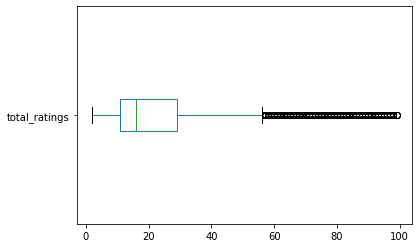

In [11]:
# Check the distribution of number of ratings per user, to validate the upper limit of ratings for filtering the users
activity['total_ratings'].plot(kind='box', vert=False)
print(activity.total_ratings.describe())

Percent of 5 star rating interactions: 79.22%
Percent of 4 star rating interactions: 15.36%
Percent of 3 star rating interactions: 3.6%
Percent of 2 star rating interactions: 1.23%
Percent of 1 star rating interactions: 0.59%


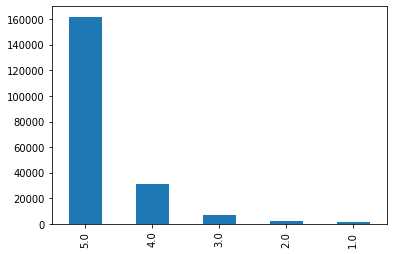

In [12]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

<a id='nlp-preprocessing'></a>
### 1.4. Preprocessing for recipe data

In [13]:
# Function to concatenate the textual data per recipe to one string used for the content based approach
def create_input (df, column_names):
    df_content = df
    df_content = df_content.assign(content= df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1))
    df_content = df_content.drop(columns = column_names)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [14]:
# Flatten recipe´s steps
content_processed = recipes_data.copy()
content_processed.steps = recipes_data.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

# Concatenate recipe name, description and steps to one string per recipe
content_processed = create_input(recipes_data[['recipe_id', 'name', 'description', 'steps']], ['name', 'description', 'steps'])

content_processed.head()

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
17,23933,"chinese candy a little different, and oh so go..."
33,54100,grilled venison burgers delicious venison burg...
34,67664,healthy for them yogurt popsicles my children ...
36,25775,how i got my family to eat spinach spinach cas...


In [15]:
# Run NLP-preprocessing on the recipe content
content_processed = get_processed(content_processed)
content_processed.shape

(20371, 2)

<a id='summary_preprocessing'></a>
### 1.5 Remaining data size

In [16]:
n_recipes = len(content_processed)
n_users = len(interactions.user_id.unique())
print(f'Number of recipes: {n_recipes}')
print(f'Number of users: {n_users}')
print(f'Number of interactions: {len(interactions)}')

# Free some memory
del interactions_raw, recipes_raw, interactions_data

Number of recipes: 20371
Number of users: 8431
Number of interactions: 204223


## 2. Train-Test-Split

In [17]:
def get_fixedN_test_train_split(interactions, n):
    """
    Parameters
    ---------
    
    Returns
    ---------
    test_split: DataFrame
        Interactions DataFrame containing only n interactions per user
    train_split: DataFrame
        Interactions DataFrame containing the rest of the interactions
    """
    
    test_split = pd.DataFrame(columns = ['user_id', 'recipe_id', 'rating'])
    groups = interactions.groupby('user_id')
    
    #with progressbar.ProgressBar(max_value=len(interactions.user_id.drop_duplicates().values)) as bar:
    for i, group in groups:
        test_shard = group.sample(n=n, random_state=10)
        test_split = pd.concat([test_split, test_shard], ignore_index=True)
            
    interactions = interactions.set_index(['user_id', 'recipe_id']).sort_index()    
    test_split = test_split.set_index(['user_id', 'recipe_id']).sort_index()
    train_split = interactions[~interactions.index.isin(test_split.index)]
    
    train_split.reset_index(inplace=True)
    test_split.reset_index(inplace=True)
    
    
    return train_split, test_split

In [18]:
#Create train-test split of interaction data by keeping a fixed number of interactions per user for testing
fixed_n_test = 3
train_split, test_split = get_fixedN_test_train_split(interactions, fixed_n_test)

Test size: 14.14% 

Rating distribution in test set 

Percent of 5 star rating interactions: 79.6%
Percent of 4 star rating interactions: 14.72%
Percent of 3 star rating interactions: 3.61%
Percent of 2 star rating interactions: 1.41%
Percent of 1 star rating interactions: 0.66%


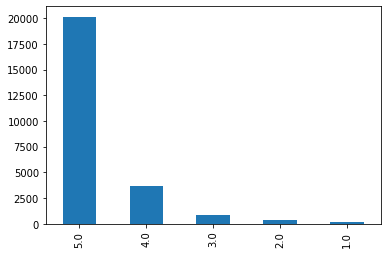

In [19]:
# Validate quality of train-test split
print(f'Test size: {round((len(test_split)/len(train_split))*100,2)}% \n')
print('Rating distribution in test set \n')
get_rating_dist(test_split.rating)

<a id='models'></a>
## 3. Models

<a id='general-functions'></a>
###  General functions

<a id='recommendation-functions'></a>
#### Recommendations functions for precision

In [57]:
#return top k predicted ratings in readable form 

# IMPORTANT: must set the dataframe for recipe_info index == recipe_id!
def get_user_recommendations(user_id, similarity, content, interactions, recipe_info, k):
    """
     Returns
    ----------
    info:
        HTML dataframe with recommendation information
    """
    #get top k recipe ids
    topk_recipes, predictions, recipeurls, imageurls = get_topk_recipes(user_id, similarity, content, interactions, k)
    info = recipe_info.loc[topk_recipes]
    info = info[['name', 'minutes', 'submitted', 'description']]
    info['prediction'] = predictions
    info['recipeurl'] = recipeurls
    info['imageurl'] = imageurls
    for index, row in info.iterrows():
        info.at[index, 'recipeurl'] = '<a href="'+ row['recipeurl'] + '">'+row['recipeurl'] +'</a>'
        info.at[index, 'imageurl'] = '<a href="'+ row['imageurl'] + '"> Image of recipe '+str(index)+'</a>'
    info = HTML(info.to_html(escape=False))
    return info

def get_topk_recipes(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    #new_predictions = prediction_df[prediction_df['has_rated'] == False]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    imageurls = []
    recipeurls = []
    for entry in topk_recipes:
        recipeurls.append("https://www.food.com/recipe/" + str(entry))
        imageurls.append(get_image_source_url(entry))
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes, predictions, recipeurls, imageurls

#return predictions for 1 user
def get_user_preference(user_id, similarity, content, interactions_data):
    """
     Returns
    ----------
    prediction_df:
        DataFrame in with columns ['recipe_id','prediction', 'has_rated'] for 1 user
    """
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions_data.loc[interactions_data['user_id']==user_id, 'recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id, interactions_data)
    
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim/norm_const
    
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index=content['recipe_id'].values, columns =['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions
    return prediction_df

#arrange ratings for matrix multiplication
def get_reshaped_ratings(user_id, interactions_data):
    ratings = interactions_data.loc[interactions_data['user_id']==user_id, :]
    ratings.set_index('recipe_id', inplace=True)
    ratings.index.set_names(None, inplace = True)
    ratings = ratings.drop(columns='user_id')
    ratings = ratings.transpose()
    ratings.rename(index={'rating':user_id}, inplace=True)
    return ratings.loc[ratings.index==user_id]

In [248]:
def make_all_recommendations(user_ids, similarity, content, interactions, k):
    """
    Params
    --------
    user_ids: Array
        list of user ids
    similarity: Array 
        similarity matrix with shape (#recipes, #recipes).
    content: DataFrame
        processed DataFrame with ['recipe_id', 'content'] used to fetch all recipes ids to make recommendations for 
        (=total training data)
    interactions: DataFrame
        preprocessed interactions DataFrame ['recipe_id', 'user_id', 'rating']     
    k: integer
        number of recommendations to make
    Returns:
    --------
    nested_recommendations:
        nested list of recommended recipe_ids for each user in param list
        example:[[rid1, rid20, rid30...], [rid1, rid20, rid30...],[rid1, rid20, rid30...]]
    """
    pbar = ProgressBar()
    nested_recommendations={}
    for i in pbar(range(len(user_ids))):
        recs = get_topk_recipes_lean(user_ids[i], similarity, content, interactions, k)
        nested_recommendations[user_ids[i]] = recs
    return nested_recommendations

def get_topk_recipes_lean(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id, similarity, content, interactions)
    #filter the already rated recipes (we do not recommend those)
    prediction_df = prediction_df.loc[prediction_df.has_rated == False]
    #sort predictions
    ordered_predictions = prediction_df.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].tolist()
    predictions = ordered_predictions.prediction[:k].tolist()
    return topk_recipes

<a id='prediction-functions'></a>
#### Prediction function for RMSE

In [59]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated)/np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [60]:
def make_all_predictions(num_interactions, similarity, content, interactions, uid_array, rids_array):
    predictions_cos = []
    actual_cos = []
    pbar = ProgressBar()
    
    for i in pbar(range(num_interactions)):
        act, pred = get_one_prediction(similarity, content, interactions, uid_array[i], rids_array[i])
        predictions_cos.append(pred)
        actual_cos.append(act)
        
    return predictions_cos, actual_cos

### 3.1 Content-Based Models

<a id='cosine'></a>
### 3.1.1 Cosine similarity

<a id='tfidf-svd'></a>
#### Proximity Matrix (TFIDF/SVD)

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [62]:
def get_cos_sim_matrix(processed, n_components=10, use_svd = True):
    '''
    Compute the cosine similarity matrix based on TF-IDF and SVD truncation
    '''
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    if use_svd:
        #reduce dimensionality of tfidf matrix
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        tfidf_truncated = svd.fit_transform(tfidf_matrix)
    else:
        tfidf_truncated = tfidf_matrix
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    return cosine_sim

#### Hyperparameter Tuning

In [63]:
def tuning_cos_rmse(n_components, content, interactions, uid_array, rids_array):
    '''
    Function computes the RMSE for different number of components for the used SVD
    '''
    rmse_cos = []
    
    for n in n_components:
        print("Computing predictions & recommendations for:", n)
        similarity = get_cos_sim_matrix(content, n)
        
        predictions, actuals = make_all_predictions(len(interactions), 
                                                    similarity, 
                                                    content, 
                                                    interactions, 
                                                    uid_array, 
                                                    rids_array)
        rmse = mean_squared_error(predictions, actuals)**0.5
        print(n, '=n_components', 'rmse:', rmse)
        rmse_cos.append(rmse)
        
           
    return rmse_cos

In [66]:
# Define a suitable parameter range for the components of the SVD
n_components=[50, 100, 200]
# Tune the actual hyperparameters
rmse_cos_tune= tuning_cos_rmse(n_components,
                               content_processed,
                               train_split,
                               train_split['user_id'].values,
                               train_split['recipe_id'].values, 
                               )
# Get the hyperparameter with the lowest RMSE on the dev set
rmse_cos_tune_min = min(rmse_cos_tune)
rmse_cos_tune_min_idx = rmse_cos_tune.index(rmse_cos_tune_min)
n_components_min = n_components[rmse_cos_tune_min_idx]

Computing predictions & recommendations for: 50


100% |########################################################################|


50 =n_components rmse: 0.5148394445001025
Computing predictions & recommendations for: 100


100% |########################################################################|


100 =n_components rmse: 0.4915770017638231
Computing predictions & recommendations for: 200


100% |########################################################################|


200 =n_components rmse: 0.46625687790375236


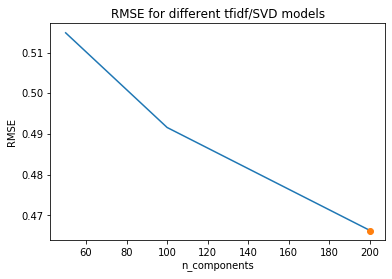

In [67]:
# Plot the RMSE for different numbers of components
plt.plot(n_components, rmse_cos_tune)
plt.xlabel('n_components')
plt.ylabel('RMSE')
plt.title('RMSE for different tfidf/SVD models')
plt.plot([n_components_min], [rmse_cos_tune_min], 'o')
plt.show()

#### Fit the models

In [69]:
# Proximity matrix of the TFIDF-SVD model
similarity_matrix_svd = get_cos_sim_matrix(content_processed, n_components_min, use_svd=True)

In [91]:
# Proximity matrix for the plain TFIDF model
similarity_matrix = get_cos_sim_matrix(content_processed, n_components_min, use_svd=False)

<a id='word-embeddings'></a>
### 3.1.2 WordEmbeddings

#### Proximity Matrix

In [72]:
def normalize_tfidf(tfidf_vector, weights):
    return(np.average(normalize(tfidf_vector), weights=weights, axis=0))

def get_tfidf_wordembedding_matrix(content_separated, vocabulary_name):
    # Load pre-trained vocabulary
    model = api.load(vocabulary_name) # glove-wiki-gigaword-100 glove-wiki-gigaword-200 glove-wiki-gigaword-300
    word2vector = dict(zip(model.wv.index2word, model.wv.vectors))

    # Compute tf-idf vector
    tfidf = TfidfVectorizer(analyzer=lambda x: x)
    tfidf.fit(content_separated)

    # create dictionary with all vocabulary items and their tf-idf distance
    max_idf = max(tfidf.idf_)
    word2word = collections.defaultdict(
        lambda: max_idf,
        [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

    # get representation of contents as tf-idf (second dimension used for weights)
    dim = len(word2vector.items())
    tfidf_matrix = np.array([
        normalize_tfidf([word2vector[w] * word2word[w] for w in words if w in word2vector]
                        or [np.zeros(dim)], [word2word[w] for w in words if w in word2vector] or 0)
        for words in content_separated
    ])
    
    return tfidf_matrix

#### Hyperparameter Tuning

In [73]:
def tuning_emb_vocab_size(vocabulary_names, content, content_seperated, interactions, uid_array, rids_array):
    rmse_emb = []
    
    for vocabulary_name in vocabulary_names:
        tfidf_matrix = get_tfidf_wordembedding_matrix(content_seperated, vocabulary_name)
        similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
        
        predictions, actuals = make_all_predictions(len(interactions), similarity, content, interactions, uid_array, rids_array)
        rmse = mean_squared_error(predictions, actuals)**0.5
        rmse_emb.append(rmse)

    return rmse_emb

In [74]:
# Parameter space for the word embedding model, parameters represent size of embedding
vocabulary_names = ["glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200", "glove-wiki-gigaword-300"]
# Tokenized content required to tune the parameters
content_tokenized = [content_item.split(" ") for content_item in content_processed["content"]]
# Choose the size with the smallest RMSE on the dev set
rmse_emb_tune = tuning_emb_vocab_size(vocabulary_names,
                                      content_processed,
                                      content_tokenized,
                                      train_split,
                                      train_split['user_id'].values,
                                      train_split['recipe_id'].values)
rmse_emb_min = min(rmse_emb_tune)
rmse_emb_min_idx = rmse_emb_tune.index(rmse_emb_min)
vocabulary_name_min = vocabulary_names[rmse_emb_min_idx]

C:\Users\Bene\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
100% |########################################################################|


[==================================================] 100.0% 128.1/128.1MB downloaded


C:\Users\Bene\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
100% |########################################################################|


[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 36.7% 92.5/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.0% 224.5/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 252.1/252.1MB downloaded


C:\Users\Bene\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
100% |########################################################################|


[===-----------------------------------------------] 6.5% 24.5/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 376.1/376.1MB downloaded


C:\Users\Bene\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
100% |########################################################################|


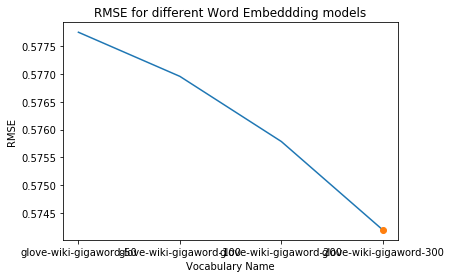

In [75]:
# Plot the RMSE for different sizes of word embeddings
plt.plot(vocabulary_names, rmse_emb_tune)
plt.xlabel('Vocabulary Name')
plt.ylabel('RMSE')
plt.title('RMSE for different Word Embeddding models')
plt.plot([vocabulary_name_min], [rmse_emb_min], 'o')
plt.show()

#### Fit the model

In [90]:
# Proximity matrix of the embedded model
tfidf_matrix = get_tfidf_wordembedding_matrix(content_tokenized, vocabulary_name_min)
similarity_matrix_embedded = cosine_similarity(tfidf_matrix, tfidf_matrix)

C:\Users\Bene\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


<a id='mixture'></a>
### 3.1.3 Mixture Model

#### Proximity Matrix

In [80]:
def get_mix_sim_matrix(processed, lmbda, df_rfiltered):
    '''
    Function to compute proximity matrix for the mixture model
    '''
    cos_sim = get_cos_sim_matrix(processed, n_components_min, False)
    df_sub = df_rfiltered[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
    df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')
    scaler = StandardScaler()
    X = scaler.fit_transform(df_processed)
    eucl_dis = euclidean_distances(X,X)
    eucl_sim = 1/np.exp(eucl_dis)
    mixed_sim = np.add(cos_sim*lmbda, eucl_sim*(1-lmbda)) # assume equally weighted
    return mixed_sim

<a id='optimize-lambda'></a>
#### Hyperparamter Tuning

In [81]:
def tuning_mix_param(lmbdas, content, df_rfiltered, interactions, uid_array, rids_array):
    '''
    Function computes the RMSE for different sizes of lambda (weighting parameter of the mixture model)
    '''
    rmse_mix = []
    
    for lmbda in lmbdas:
        similarity = get_mix_sim_matrix(content, lmbda, df_rfiltered)
        
        predictions, actuals = make_all_predictions(len(interactions), 
                                                    similarity, 
                                                    content, interactions, 
                                                    uid_array, 
                                                    rids_array)
        rmse = mean_squared_error(predictions, actuals)**0.5
        rmse_mix.append(rmse)
           
    return rmse_mix

In [82]:
# Set a suitable parameter range for lambda
lmbdas = np.linspace(0,1,5)
# Compute the RMSE for different lambdas (weighting paramtere)
rmse_mix_tune = tuning_mix_param(lmbdas, 
                                 content_processed,
                                 recipes_data,
                                 train_split, 
                                 train_split['user_id'].values, 
                                 train_split['recipe_id'].values)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


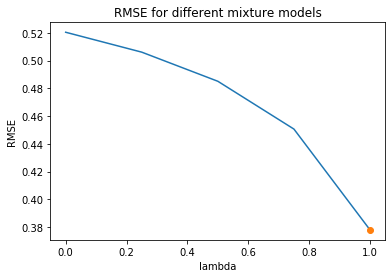

In [83]:
# Plot the RMSE for different sizes of lambda
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

#### Fit the model

In [84]:
# Proximity matrix of the mixture model
similarity_matrix_mixed = get_mix_sim_matrix(content_processed, lmbda_min, recipes_data)

### 3.2 Collaborative Filtering Models

In [124]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    # Just keep the recipe ids
    for uid, user_ratings in top_n.items():
        recommended_recipes = []
        for user_rating in user_ratings:
            recommended_recipes.append(user_rating[0])
        top_n[uid] = recommended_recipes

    return top_n

#### Preselection of algorithms

In [86]:
# Compare Results of default algorihms on the problem to identify most promising once

algos = {
    'NormalPredictor': NormalPredictor, 
    'BaselineOnly': BaselineOnly, 
    'KNNBasic': KNNBasic, 
    'KNNWithMeans': KNNWithMeans,
    'KNNWithZScore': KNNWithZScore,
    'KNNBaseline': KNNBaseline,
    'SVD': SVD,
}

# Build cross validation split
cv_cf = ShuffleSplit(n_splits = 10, test_size = 0.3, random_state=42, shuffle=True)

# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(train_split[['user_id','recipe_id', 'rating']], Reader())
# Results dict
results_algos_cf = {}

# Evaluate each algorithm with default settings
for name, algo in algos.items():
    cs = cross_validate(algo(), trainset, cv=cv_cf, n_jobs=-1)
    results_algos_cf.update({name: [np.mean(cs.get('test_rmse'))]})

results_algos_cf_df = pd.DataFrame.from_dict(results_algos_cf, orient='index', columns=['DevRMSE'])
results_algos_cf_df

,DevRMSE
NormalPredictor,0.811425
BaselineOnly,0.607315
KNNBasic,0.720058
KNNWithMeans,0.670449
KNNWithZScore,0.678394
KNNBaseline,0.672243
SVD,0.611749


#### Hyperparameter Tuning

In [87]:
# Evaluate each algorithm with tuned parameters
algos = { 
    'BaselineOnly': BaselineOnly,
    'KNNBaseline': KNNBaseline,
    'SVD': SVD,
}

# Store the fitted algorithms for later use
fitted_algos = {}

# List to store the final results for the estimators in
benchmark = []

# Define the parameter grid
param_grid = {
    "KNNBaseline" : {
        "k" : [10, 20, 40, 80],
        "sim_options" : {
            'user_based': [True, False],
            "name" : ['cosine', 'msd']
        },
    },     
    "SVD" : {
        "n_factors" : [5, 10, 100],
        "lr_all": [0.0025, 0.005, 0.01],
        "reg_all": [0.01, 0.02, 0.04]
    },
    "BaselineOnly" : {}
}

for name, algo in algos.items():
    print(name)
    gs = GridSearchCV(algo, param_grid.get(name), measures=['rmse'], cv=cv_cf, refit=False)
    
    start_gs = time.time()
    # Fit the estimator
    gs.fit(trainset)
    end_gs = time.time()
    print(f'GridSearch: {round(end_gs-start_gs, 2)}s')
    
    # Get the best results per estimator
    best_index_rmse = gs.best_index['rmse']
    best_params_rmse = gs.best_params['rmse']
    rmse = gs.cv_results['mean_test_rmse'][best_index_rmse]
    
    # Store the results
    benchmark.append([name, rmse, best_params_rmse])

# Display the results
results_cf_df = pd.DataFrame(benchmark, columns=["Algorithm", "DevRMSE", "BestParams"])
results_cf_df.set_index(["Algorithm"], inplace=True)
results_cf_df.sort_values('DevRMSE', inplace=True)
results_cf_df

BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
GridSearch: 10.69s
KNNBaseline
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Esti

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similar

,DevRMSE,BestParams
Algorithm,,
SVD,0.605205,"{'n_factors': 5, 'lr_all': 0.005, 'reg_all': 0..."
BaselineOnly,0.607315,{}
KNNBaseline,0.619317,"{'k': 10, 'sim_options': {'user_based': True, ..."


<a id='evaluation'></a>
## 4. Evaluation

### 4.1 Single Algorithms Classification Metrics

Test size: 16.46% 

Rating distribution in test set 

Percent of 5 star rating interactions: 79.16%
Percent of 4 star rating interactions: 15.19%
Percent of 3 star rating interactions: 3.61%
Percent of 2 star rating interactions: 1.28%
Percent of 1 star rating interactions: 0.76%


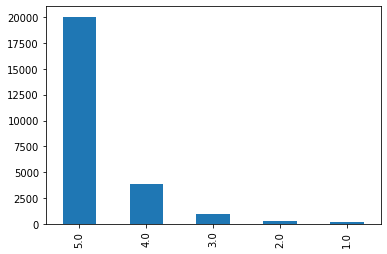

In [88]:
# Create a train dev split the same way we created the train test split (only single possible) ==> Fixed N
# Required as we used different splits for hyperparameter tuning for content based and collaborative filtering
# To compare the classification metrics, we have to use the same split
fixed_n_dev = 3
train_split, dev_split = get_fixedN_test_train_split(train_split, fixed_n_dev)
# Validate quality of train-dev split
print(f'Test size: {round((len(dev_split)/len(train_split))*100, 2)}% \n')
print('Rating distribution in test set \n')
get_rating_dist(dev_split.rating)

In [ ]:
# Define k for the number of Top recipes
k = 10

# Store the resuls of the different models
benchmark = []

# Calculate scores for content based models
content_based_models = {
    'Cosine SVD Model': get_cos_sim_matrix(content_processed, n_components_min, use_svd=True),
    'Cosine Plain Model': get_cos_sim_matrix(content_processed, n_components_min, use_svd=False),
    'Embedded Cosine Model': similarity_matrix_embedded = cosine_similarity(tfidf_matrix, tfidf_matrix),
    'Mixture Model': similarity_matrix_mixed = get_mix_sim_matrix(content_processed, lmbda_min, recipes_data)
}

for m_name, model in content_based_models.items():
    rec_dict = make_all_recommendations(dev_split.user_id.unique(), model, content_processed, train_split, k)

    # Compute metrics
    # Catalog coverage
    cat_cov = catalog_coverage(rec_dict, n_recipes)
    # Get hits per user (required for other metrics)
    n_hits_per_user = get_hits(rec_dict, dev_split)
    # Average precision
    precision = get_avg_precision(n_hits_per_user, k)
    # Average recall
    recall = get_avg_recall(n_hits_per_user, fixed_n_dev)
    # f1-score
    f_one = get_f_one(precision, recall)
    # Hitrate
    hitr = hitrate(n_hits_per_user)
    
    benchmark.append([m_name, cat_cov, precision, recall, f_one ,hitr])


# Prepare train and dev set for algos
# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(train_split[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset()
devset = trainset.build_anti_testset()

algos = { 
    'BaselineOnly': BaselineOnly(),
    'KNNBaseline': KNNBaseline(k=10, sim_options={'user_based': True, 'name': 'cosine'}),
    'SVD': SVD(n_factors=5, lr_all=0.005, reg_all=0.04),
}

for name, algo in algos.items():
    print(name)
    print("Train Started")
    # Fit the algorithm on the train set
    algo.fit(trainset)
    print("Prediction Started")
    # Get predictions on dev set
    predictions = algo.test(devset)
    # Get Top k recipes
    rec_dict = get_top_n(predictions, k)
    # Catalog coverage
    cat_cov = catalog_coverage(rec_dict, n_recipes)
    # Get hits per user (required for other metrics)
    n_hits_per_user = get_hits(rec_dict, dev_split)
    # Average precision
    precision = get_avg_precision(n_hits_per_user, k)
    # Average recall
    recall = get_avg_recall(n_hits_per_user, fixed_n_dev)
    # f1-score
    f_one = get_f_one(precision, recall)
    # Hitrate
    hitr = hitrate(n_hits_per_user)
    
    benchmark.append([name, cat_cov, precision, recall, f_one, hitr])
    
benchmark_df = pd.DataFrame(benchmark, columns=['Model', 'Catalog Coverage', 'Precision', 'Recall', 'f1' ,'Hitrate'])
benchmark_df.set_index('Model', inplace = True)
benchmark_df

BaselineOnly
Train Started
Estimating biases using als...
Prediciton Started


### 4.2 Hybrid Model

#### Tune hyperparameters

#### Fit the hybrid model

### 4.3 Final Scores

In [ ]:
# Test set for suprise package
testset = Dataset.load_from_df(test_split[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset().build_testset()